# Methods for comparing two observed confusion matrices

This notebook implements tests for two observed confusion matrices to evaluate two assignation procedures.

The notebook implementation is based on a paper: José Rodríguez-Avi, Francisco Javier Ariza-López, Mª Virtudes Alba-Fernández - Methods for comparing two observed confusion matrices, Proceedings 2018, The 21st AGILE International Conference on Geographic Information Science [download link](https://agile-online.org/conference_paper/cds/agile_2018/posters/96%20Poster%2096.pdf)

Python implementation by Nikola Mirkov (largeddysimulation@gmail.com)

### Enter two confusion matrices by hand for this example

In [15]:
DL = np.array([[96,1,36,1,0,0,15,1,9,11],[1,157,1,0,0,1,1,4,0,5],[35,1,116,3,2,0,6,1,0,6],[0,0,0,120,29,12,0,2,7,0],[4,0,6,1,140,18,0,0,0,1],[14,0,16,0,16,120,0,0,0,4],[4,0,11,0,1,0,142,7,0,5],[0,2,0,0,0,0,47,118,0,3],[0,0,0,11,0,1,0,1,157,0],[3,1,10,6,3,1,12,13,2,119]])
print(DL)

[[ 96   1  36   1   0   0  15   1   9  11]
 [  1 157   1   0   0   1   1   4   0   5]
 [ 35   1 116   3   2   0   6   1   0   6]
 [  0   0   0 120  29  12   0   2   7   0]
 [  4   0   6   1 140  18   0   0   0   1]
 [ 14   0  16   0  16 120   0   0   0   4]
 [  4   0  11   0   1   0 142   7   0   5]
 [  0   2   0   0   0   0  47 118   0   3]
 [  0   0   0  11   0   1   0   1 157   0]
 [  3   1  10   6   3   1  12  13   2 119]]


In [17]:
RF = np.array([[93,0,27,0,0,2,18,4,13,13],[0,160,0,0,0,0,2,4,0,4],[25,0,122,2,0,4,6,3,0,8],[0,0,0,119,21,19,0,0,9,2],[0,0,3,0,124,33,2,0,0,8],[0,0,0,0,38,125,0,0,0,7],[0,0,21,0,2,0,125,2,0,20],[0,0,1,0,0,0,48,118,0,3],[0,0,0,5,0,0,0,0,164,1],[0,0,2,4,2,2,7,21,2,130]])
print(RF)

[[ 93   0  27   0   0   2  18   4  13  13]
 [  0 160   0   0   0   0   2   4   0   4]
 [ 25   0 122   2   0   4   6   3   0   8]
 [  0   0   0 119  21  19   0   0   9   2]
 [  0   0   3   0 124  33   2   0   0   8]
 [  0   0   0   0  38 125   0   0   0   7]
 [  0   0  21   0   2   0 125   2   0  20]
 [  0   0   1   0   0   0  48 118   0   3]
 [  0   0   0   5   0   0   0   0 164   1]
 [  0   0   2   4   2   2   7  21   2 130]]


### Create a class for confusion matrix comparison

In [225]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

class Confusion_mat_comparison:
    '''
    Purpose:
    A class implementing confusion matrix comparison.
    
    Desription:
    You need to give two matrices as input argument and run various tests
    implemented as methods of the class.
    
    Implemented test methods are:
    1) Single binomial contrast (called by: Test_instance_name.single_binomial_contrast(args) )
    2) Mutiple binomial contrast (called by: Test_instance_name.multiple_binomials_contrast(args) )
    3) Overall chi-square test (called by Test_instance_name.chi_square(args))
    
    Reference: 
    J. Rodrigues-Avi et al., "Methods for comparing two observed conusion matrices",...(201X)
    
    '''
    def __init__(self, MatA:np.array, MatB:np.array):
        self.A = MatA
        self.B = MatB
        
    def get_nm(self):
        n = np.sum(self.A[:,:])
        m = np.sum(self.B[:,:])
        print("Total number of elements classified in A: {}, and B: {}".format(n,m) )
        
    def single_binomial_contrast(self,tol):
        '''
        Purpose:
        This test compares the global proportion of 
        concordant elements in both classifications.
        Null hypothesis is that these two proportions are the same.
           
        Arguments:
        tol (input) - tolerance level for rejection of null hypothesis.
        '''
        print("Null hypothesis is that these two proportions are the same.")
        n = np.sum(self.A[:,:])
        piA = sum(np.diag(self.A))/float(n)
        print("Concordant elements proportion in 1st matrix: {:.6f}".format(piA) )
        m = np.sum(self.B[:,:])
        piB = sum(np.diag(self.B))/float(m)
        print("Concordant elements proportion in 2nd matrix: {:.6f}".format(piB) )
        if ( piA-piB < tol ):
            print("Global proportion of concordant elements is the same!")
        else:
            print("Global proportion of concordant elements differs by: {}, \nNull hypothesis rejected!". 
                  format( abs(piA-piB) ) ) 
            
    def multiple_binomials_contrast(self, tol, column=True):
        '''
        Function: multiple_binomials_contrast
        
        Purpose:
        This test makes individual tests by rows or columns.
        Default is test by columns.
           
        Description:
        We split problem into k-null hypotheses.
        Then we find Z estimator and fit it to normal distribution.
        After that k p-values are obtained, where k is the matrix size.
        p-values are then corrected using Bonferonni's correction to assure
        Type I error level.
           
        Arguments:
        tol - tolerance for pairwise comparison (eg. tol=1e-6)
        column - (optional) True/False, if true column-wise estimators
        are produced, if false rwo-wise estimators are produced.
        '''
        k = self.A.shape[1]
        Z = np.zeros(k)
        if(column):
            print("\nColumn-wise estimators for 1st and 2nd matrix and k-th null hypothesis testing:\n")
            for j in range( k ):
                n_plj = np.sum( self.A[:,j] )
                piAj = self.A[j,j] / float(n_plj)
                m_plj = np.sum( self.B[:,j] )
                piBj = self.B[j,j] / float(m_plj)            
                print( "Column {} : {} {} {}". format(j, piAj, piBj, (abs(piAj-piBj)<tol) ) )
                Z[j] = (piAj-piBj)/np.sqrt( piAj*(1-piAj)/ float(n_plj) + piBj*(1-piBj)/ float(m_plj) )
        else:
            print("\nRow-wise estimators for 1st and 2nd matrix and k-th null hypothesis testing:\n")
            for j in range( k ):
                n_plj = np.sum( self.A[j,:] )
                piAj = self.A[j,j] / float(n_plj)
                m_plj = np.sum( self.B[j,:] )
                piBj = self.B[j,j] / float(m_plj)            
                print( "Row {} : {} {} {}". format(j, piAj, piBj, (abs(piAj-piBj)<tol) ) )
                Z[j] = (piAj-piBj)/np.sqrt( piAj*(1-piAj)/ float(n_plj) + piBj*(1-piBj)/ float(m_plj) )
        #print(Z)
        mu, std = sps.norm.fit(Z)
        #print(mu,std)
        # Plot distribution
        plt.hist(Z, bins = 5, density=True, alpha=0.8, color='b')
        # Plot PDF of normal distribution
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin,xmax, 100)
        p = sps.norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=1)
        title = "Fit results for Z-vector: mu=%.3f, std=%.3f" % (mu,std)
        plt.title(title)
        plt.show()
        
        # Cumulative distribution for the test statistics
        cdfts = sps.norm.cdf( abs(Z) )
        pval = 2*(1-cdfts) # p-value for two-sided test
        pvalcorr = pval/k  # Bonferonni's correction
        print("\nk p-values and Bonferonni's correction:\n")
        for j in range(k):
            print("{} : {:.4f} {:.4f}".format(j, pval[j], pvalcorr[j]))
            
    def chi_square(self,column=True):
        '''
        Purpose:
        Peform overall chi-square test.
        
        Desription:
        Performs a chis-aquare test on sqare of Z vector obtained in 
        the way described in multiple_binomials_contrast test.
        This vector follows Chi-squared distribution.
        If observed statistics doesn't obey this - the Null hypothesis
        of whole equality of given confusion matrices is rejected.
        Further inquiry may give rejection causes.
        
        Arguments:
        column - (optional) True/False, if true column-wise estimators
        are produced, if false rwo-wise estimators are produced.
        '''
        k = self.A.shape[1]
        Z = np.zeros(k)
        if(column):
            #print("\nColumn-wise estimators for 1st and 2nd matrix and k-th null hypothesis testing:\n")
            for j in range( k ):
                n_plj = np.sum( self.A[:,j] )
                piAj = self.A[j,j] / float(n_plj)
                m_plj = np.sum( self.B[:,j] )
                piBj = self.B[j,j] / float(m_plj)            
                #print( "Column {} : {} {} {}". format(j, piAj, piBj, (abs(piAj-piBj)<tol) ) )
                Z[j] = (piAj-piBj)/np.sqrt( piAj*(1-piAj)/ float(n_plj) + piBj*(1-piBj)/ float(m_plj) )
        else:
            #print("\nRow-wise estimators for 1st and 2nd matrix and k-th null hypothesis testing:\n")
            for j in range( k ):
                n_plj = np.sum( self.A[j,:] )
                piAj = self.A[j,j] / float(n_plj)
                m_plj = np.sum( self.B[j,:] )
                piBj = self.B[j,j] / float(m_plj)            
                #print( "Row {} : {} {} {}". format(j, piAj, piBj, (abs(piAj-piBj)<tol) ) )
                Z[j] = (piAj-piBj)/np.sqrt( piAj*(1-piAj)/ float(n_plj) + piBj*(1-piBj)/ float(m_plj) )
        
        #Z-squared:
        Zsq = Z*Z
        chisq, pval = sps.chisquare(Zsq)
        print("Chi-squred test statistic: {:.3f}, p-value of the test: {:.6f}".format(chisq,pval))
    
    def multinomial_distance_bootstrap(self):
        '''
        Purpose:
        Peform multinomial distance bootstrap test.
        
        Desription:
        Obtain vectors from confusion matrices and estimate distance 
        between these vectors.
        
        Arguments:

        '''
        a = (self.A).flatten()
        b = (self.B).flatten()
        dist = np.sum( (np.sqrt(a)-np.sqrt(b))**2 )
        n = np.sum(self.A[:,:])
        m = np.sum(self.B[:,:])
        Tnm = 4*(n+m)*dist
        print( "Estimate distance between vectors: {:.6f}, {:.6f}".format(dist,Tnm) )        
        
        

In [226]:
Test = Confusion_mat_comparison(DL,RF)
print(Test.__doc__)
print(Test.multiple_binomials_contrast.__doc__)


    Purpose:
    A class implementing confusion matrix comparison.
    
    Desription:
    You need to give two matrices as input argument and run various tests
    implemented as methods of the class.
    
    Implemented test methods are:
    1) Single binomial contrast (called by: Test_instance_name.single_binomial_contrast(args) )
    2) Mutiple binomial contrast (called by: Test_instance_name.multiple_binomials_contrast(args) )
    3) Overall chi-square test (called by Test_instance_name.chi_square(args))
    
    Reference: 
    J. Rodrigues-Avi et al., "Methods for comparing two observed conusion matrices",...(201X)
    
    

        Function: multiple_binomials_contrast
        
        Purpose:
        This test makes individual tests by rows or columns.
        Default is test by columns.
           
        Description:
        We split problem into k-null hypotheses.
        Then we find Z estimator and fit it to normal distribution.
        After that k p-values are obt

In [89]:
Test.get_nm()

Total number of elements classified in A: 1700, and B: 1700


#### A single binomial contrast test

In [184]:
tolerance = 1e-6
Test.single_binomial_contrast(tolerance)

Null hypothesis is that these two proportions are the same.
Concordant elements proportion in 1st matrix: 0.755882
Concordant elements proportion in 2nd matrix: 0.752941
Global proportion of concordant elements differs by: 0.002941176470588225, 
Null hypothesis rejected!



Column-wise estimators for 1st and 2nd matrix and k-th null hypothesis testing:

Column 0 : 0.6114649681528662 0.788135593220339 False
Column 1 : 0.9691358024691358 1.0 False
Column 2 : 0.5918367346938775 0.6931818181818182 False
Column 3 : 0.8450704225352113 0.9153846153846154 False
Column 4 : 0.7329842931937173 0.6631016042780749 False
Column 5 : 0.7843137254901961 0.6756756756756757 False
Column 6 : 0.6367713004484304 0.6009615384615384 False
Column 7 : 0.8027210884353742 0.7763157894736842 False
Column 8 : 0.8971428571428571 0.8723404255319149 False
Column 9 : 0.7727272727272727 0.6632653061224489 False


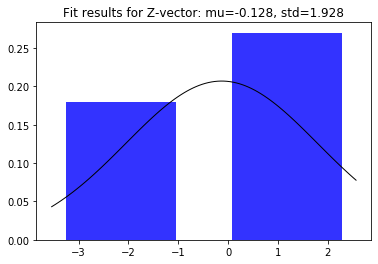


k p-values and Bonferonni's correction:

0 : 0.0011 0.0001
1 : 0.0231 0.0023
2 : 0.0402 0.0040
3 : 0.0711 0.0071
4 : 0.1380 0.0138
5 : 0.0232 0.0023
6 : 0.4442 0.0444
7 : 0.5752 0.0575
8 : 0.4586 0.0459
9 : 0.0219 0.0022

Row-wise estimators for 1st and 2nd matrix and k-th null hypothesis testing:

Row 0 : 0.5647058823529412 0.5470588235294118 False
Row 1 : 0.9235294117647059 0.9411764705882353 False
Row 2 : 0.6823529411764706 0.7176470588235294 False
Row 3 : 0.7058823529411765 0.7 False
Row 4 : 0.8235294117647058 0.7294117647058823 False
Row 5 : 0.7058823529411765 0.7352941176470589 False
Row 6 : 0.8352941176470589 0.7352941176470589 False
Row 7 : 0.6941176470588235 0.6941176470588235 True
Row 8 : 0.9235294117647059 0.9647058823529412 False
Row 9 : 0.7 0.7647058823529411 False


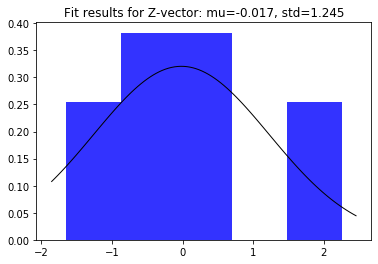


k p-values and Bonferonni's correction:

0 : 0.7433 0.0743
1 : 0.5168 0.0517
2 : 0.4773 0.0477
3 : 0.9055 0.0906
4 : 0.0361 0.0036
5 : 0.5454 0.0545
6 : 0.0237 0.0024
7 : 1.0000 0.1000
8 : 0.0970 0.0097
9 : 0.1767 0.0177


In [183]:
Test.multiple_binomials_contrast(tolerance)

Test.multiple_binomials_contrast(tolerance,column=False)

#### Overall chi-square test

In [218]:
Test.chi_square()

Chi-squred test statistic: 23.799, p-value of the test: 0.004631


#### Multinomial distance bootstrap test

In [227]:
Test.multinomial_distance_bootstrap()

Estimate distance between vectors: 101.997250, 1387162.600888
